# Assignment Set 1
## 1.1 Vibrating string

The problem at hand is the numerical solution of a one-dimensional wave equation, 
which might describe the vibrations of a uniform string, the transport of voltage 
and current along a lossless transmission line, the pressure and flow rate of a 
compressible liquid or gas in a pipe, sound waves in gases or liquids, and optical waves. 
In this example, the domain of the wave equation is a string.

The one-dimensional wave equation is

$$
\frac{\partial^2 \Psi}{\partial t^2}
=
c^2 \frac{\partial^2 \Psi}{\partial x^2}
$$

The solution $\Psi(x,t)$ is the vibration amplitude expressed as a function 
of position and time. The problem becomes fully posed with the addition of 
boundary conditions on the spatial domain, and initial position and velocity 
distributions.

We attempt a numerical solution method by introducing a uniform discretization 
of the spatial and temporal domains, and approximating the partial differential 
equation by finite difference expressions. The grid points of this problem consist 
of discrete nodal points at which $\Psi$ is to be evaluated.

**A. (0.5 point)** Discretize the wave equation, and write it in a form suitable for implementing in a computer program. Assume that the boundaries are fixed, 
$\Psi(x=0,t)=0$, $\Psi(x=L,t)=0$. $L$ is the length of the string. Take $L=1$ for simplicity. Divide the string in $N$ intervals, so that the interval length is 
$\Delta x = L/N$. Also consider the boundary cases.

If you use Euler’s method, you need to use both $\Psi(x,t)$ and $\Psi_t(x,t)$ as variables. Or use the stepping method from the lectures, which uses $\Psi$ at the two most recent time points to calculate it at the next one.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import json

In [2]:
import utils

In [3]:
import importlib
importlib.reload(utils) 

<module 'utils' from '/Users/quokkaaa/Desktop/SFM/Scientific Computing/Scientific_Computing/Assignment 1/utils.py'>

## 1.3 The Time Independent Diffusion Equation

Now assume that we are not very much interested in the time development of the 
concentration profile (i.e. the transient behavior), but only in the steady state. 
In that case it is possibly more effective to directly solve the time independent 
diffusion equation:

$$
\nabla^2 c = 0.
\tag{10}
$$

This is the famous Laplace equation. We again assume the same boundary 
conditions as in the previous section. Taking the same spatial discretization as before, 
and again applying the same 5-point stencil for the second order derivatives, 
eq.~(7) transforms to the following set of finite difference equations:

$$
\frac{1}{4}
\left(
c_{i+1,j}
+
c_{i-1,j}
+
c_{i,j+1}
+
c_{i,j-1}
\right)
=
c_{i,j}.
\tag{11}
$$

for all values of $(i,j)$. Note that the superscript $k$ is no longer present, 
because the time behavior is now suppressed. Many methods exist to solve the 
equations. We will here concentrate on iterative methods, because they are 
potentially efficient, and demand less memory than direct methods (and allow 
for relatively easy parallelism). A direct method is tried in exercise set 3.

## 1.4 The Jacobi Iteration

Using now the superscript $k$ to denote the $k$-th iteration, the Jacobi iteration is immediately suggested from eq.~(11):

$$
c_{i,j}^{k+1}
=
\frac{1}{4}
\left(
c_{i+1,j}^{k}
+
c_{i-1,j}^{k}
+
c_{i,j+1}^{k}
+
c_{i,j-1}^{k}
\right).
\tag{12}
$$

Note that eq.~(12) is easily derived from eq.~(7) by putting

$$
\frac{\delta t D}{\delta x^2} = \frac{1}{4}.
\tag{13}
$$

i.e. the Jacobi iteration is nothing but the solution of the time-dependent equation using the scheme from eq.~(7) with the maximum allowed time step. This suggests that more efficient iterative methods are needed.

There is one noticeable difference between the Jacobi iteration and the solution of the time dependent equation. In the time dependent case one defines the time step and the total time that should be simulated. In an iterative method one needs a stopping condition. This stopping condition typically is some global measure.

Assume that the stopping condition is such that the solution is assumed to be converged if for all values of $(i,j)$

$$
\delta
\equiv
\max_{i,j}
\left|
c_{i,j}^{k+1}
-
c_{i,j}^{k}
\right|
<
\varepsilon,
\tag{14}
$$

where $\varepsilon$ is some small number, say $10^{-5}$.

For implementing the Jacobi iteration, note that separate matrices are needed for $c_{i,j}^{k}$ and $c_{i,j}^{k+1}$; one cannot simply use one matrix and update it, as one would then overwrite values that are needed later.

In [7]:
from utils import jacobi
u, err = jacobi(50,50)


Converged after 4067 iterations.


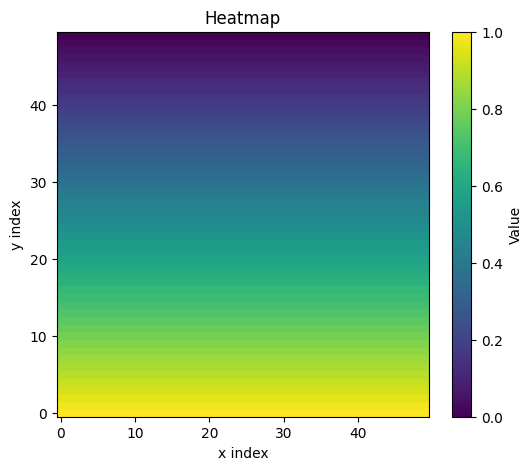

In [8]:
from visuals import plot_heatmap
plot_heatmap(u)

In [6]:
from utils import analytical_solution, compare_to_analytic
max,root_mean_square_error = compare_to_analytic(u)
max,root_mean_square_error

(np.float64(0.00972913278762777), np.float64(0.00695440046814476))

## 1.5 The Gauss–Seidel Iteration

An improvement over the Jacobi iteration is the Gauss–Seidel iteration, where during the iteration a new value is used as soon as it has been calculated. Assuming that the iteration proceeds along the rows (i.e. incrementing $i$ for fixed $j$), the Gauss–Seidel iteration reads

$$
c_{i,j}^{k+1}
=
\frac{1}{4}
\left(
c_{i+1,j}^{k}
+
c_{i-1,j}^{k+1}
+
c_{i,j+1}^{k}
+
c_{i,j-1}^{k+1}
\right).
$$

The Gauss–Seidel iteration is not a big improvement over the Jacobi iteration (in terms of the amount of iterations needed for convergence) and is only a first step in introducing the Successive Over Relaxation method (next section). However, the update can be performed *in place*.

Converged after 2383 iterations.


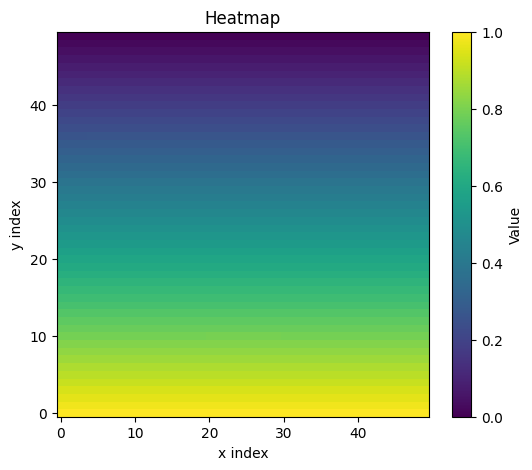

In [7]:
from utils import gauss_seidel
u_gs, err_gs = gauss_seidel(50,50)
plot_heatmap(u_gs)

In [8]:
max,root_mean_square_error = compare_to_analytic(u_gs)
max,root_mean_square_error

(np.float64(0.004917827690506749), np.float64(0.003485213647462799))

## 1.6 Successive Over Relaxation

Now that you have the parallel Gauss–Seidel iteration in place, it is easy to take the next and final step. The Gauss–Seidel iteration did not provide a huge improvement over the Jacobi iteration. A next improvement comes from the Successive Over Relaxation (SOR). SOR is obtained from Gauss–Seidel by an over-correction of the new iterate, in formula

$$
c_{i,j}^{k+1}
=
\frac{\omega}{4}
\left(
c_{i+1,j}^{k}
+
c_{i-1,j}^{k+1}
+
c_{i,j+1}^{k}
+
c_{i,j-1}^{k+1}
\right)
+
(1-\omega)c_{i,j}^{k}.
$$

This method converges only for $0 < \omega < 2$. For $\omega < 1$ the method is called under-relaxation. The new value is then the weighted average of the Gauss–Seidel method and the previous value. For $\omega = 1$ we recover the Gauss–Seidel iteration.

It turns out that for our diffusion problem the optimal $\omega$ (that minimizes the number of iterations) lies somewhere in the interval $1.7 < \omega < 2$. The exact value depends on the grid size $N$.

Converged after 311 iterations.


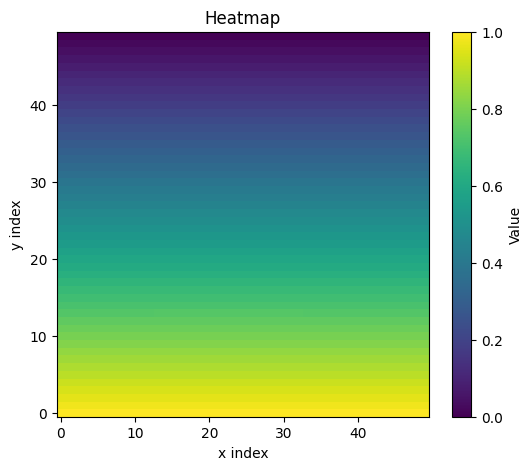

In [9]:
from utils import successive_over_relaxation
u_sor, err_sor1 = successive_over_relaxation(50,50,1.85)
plot_heatmap(u_sor)

In [10]:
max,root_mean_square_error = compare_to_analytic(u_sor)
max,root_mean_square_error

(np.float64(0.0004318835305797686), np.float64(0.0002801842255112424))

In [11]:
u_sor2, err_sor2 = successive_over_relaxation(50,50,1.75)
u_sor3, err_sor3 = successive_over_relaxation(50,50,1.90)

Converged after 493 iterations.
Converged after 333 iterations.


**I. (1 point)** Show how the convergence measure $\delta$ in eq.~(14) depends on the number of iterations $k$ for each of the methods. A log–lin plot may be suitable. For SOR, choose a few representative values for $\omega$.

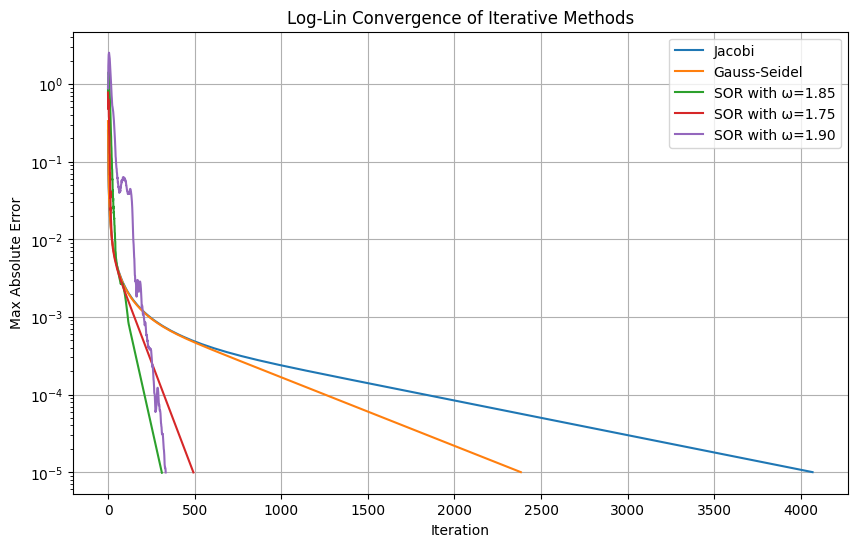

In [12]:
plt.figure(figsize=(10,6))
plt.semilogy(err, label='Jacobi')
plt.semilogy(err_gs, label='Gauss-Seidel')
plt.semilogy(err_sor1, label='SOR with ω=1.85')
plt.semilogy(err_sor2, label='SOR with ω=1.75')
plt.semilogy(err_sor3, label='SOR with ω=1.90')
plt.xlabel('Iteration')
plt.ylabel('Max Absolute Error')
plt.title('Log-Lin Convergence of Iterative Methods')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from utils import successive_over_relaxation_it
def optimal_omega(nx,ny):

    omegas = np.linspace(1.7,1.95, 15)
    best_omega = None
    best_error = 1000000

    for w in omegas:
        it = successive_over_relaxation_it(nx, ny, w)
        if it < best_error:
            best_error = it
            best_omega = w
    return best_omega   

best_omega = optimal_omega(50,50)
print(f'Optimal omega for SOR: {best_omega:.4f}')


Optimal omega for SOR: 1.8786


**J. (1 point)** In the SOR method, find the optimal $\omega$. How does it depend on N.

In [14]:
# best_omegas = []
# for N in [30,40,50,60,70,80,90,100]:
#     best_omegas.append(optimal_omega(N,N))

# plt.figure(figsize=(10,6))
# plt.plot([30,40,50,60,70,80,90,100], best_omegas, marker='o')
# plt.xlabel('Grid Size (N x N)')
# plt.ylabel('Optimal Omega')
# plt.title('Optimal Omega for SOR vs Grid Size')
# plt.grid(True)
# plt.show()      

So far we have only looked at diffusion in a rather dull domain. Now that we have an efficient iterative solver available, it is time to start including some object into the domain. So, now we assume that within our computational domain we include say a square object. We assume that the object is a sink for the diffusion concentration, that is, the concentration is zero everywhere on the object.

**K. (2 points)** Implement the possibility to include objects into the computational domain. The objects should be sinks. Experiment a little bit with some objects in the computational domain (e.g. a rectangle or a few rectangles, $\dots$). What is the influence on the number of iterations? What about the optimal $\omega$, is it influenced by the presence of objects? Look at the resulting concentration fields, and try to interpret what happens. The implementation in this exercise will also be used for diffusion-limited aggregation in Set 2.

In [4]:
from utils import successive_over_relaxation_sink


In [5]:
sink1 = [20,30,20,30,True]
sink2 = [10,20,10,20,True]
sink3 = [30,40,10,20,True]
sink  = [sink1]
sink23 = [sink2,sink3]

Converged after 188 iterations.
Converged after 158 iterations.
Converged after 311 iterations.


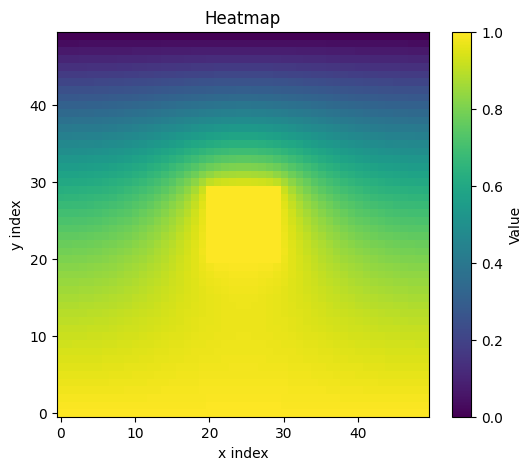

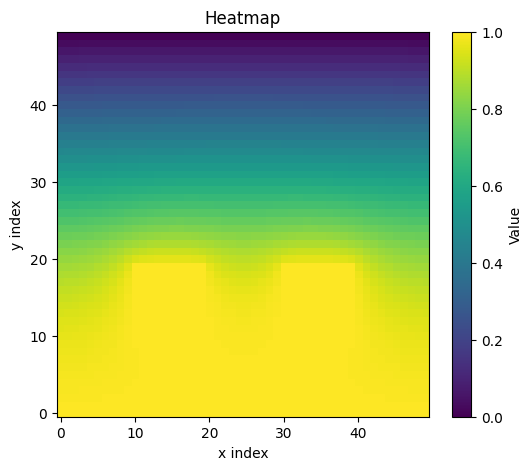

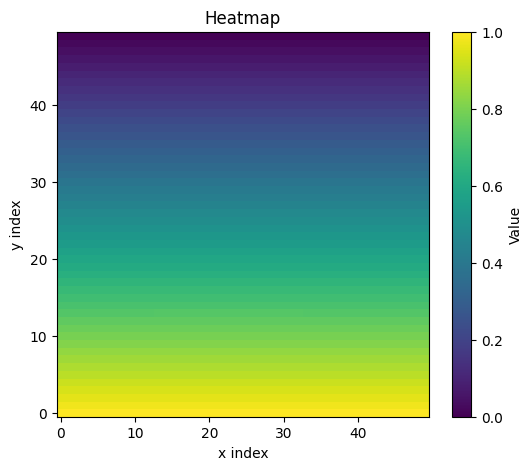

In [17]:
u_sor_sink1, err_sor_sink1 = successive_over_relaxation_sink(50,50,1.85,sinks = sink)
u_sor_sink2, err_sor_sink2 = successive_over_relaxation_sink(50,50,1.85,sinks = sink23)
u_sor, err_sor = successive_over_relaxation(50,50,1.85)
plot_heatmap(u_sor_sink1)
plot_heatmap(u_sor_sink2)
plot_heatmap(u_sor)

In [ ]:
from utils import successive_over_relaxation_sink_it
def optimal_omega(nx,ny):

    omegas = np.linspace(1.7,1.95, 10)
    best_omega = None
    best_error = 1000000

    for w in omegas:
        it = successive_over_relaxation_sink_it(nx, ny, w,sinks = sink)
        if it < best_error:
            best_error = it
            best_omega = w
    return best_omega   

best_omega = optimal_omega(50,50)
print(f'Optimal omega for SOR: {best_omega:.4f}')

Optimal omega for SOR: 1.8667


In [19]:
def optimal_omega(nx,ny):

    omegas = np.linspace(1.7,1.95, 10)
    best_omega = None
    best_error = 1000000

    for w in omegas:
        it = successive_over_relaxation_sink_it(nx, ny, w,sinks = sink23)
        if it < best_error:
            best_error = it
            best_omega = w
    return best_omega   

best_omega = optimal_omega(50,50)
print(f'Optimal omega for SOR: {best_omega:.4f}')

Optimal omega for SOR: 1.8389


Converged after 281 iterations.


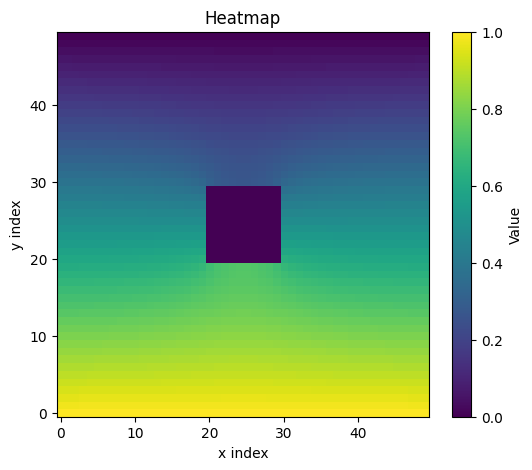

In [9]:
from utils import successive_over_relaxation_insulating
u_sor_insulating, err_sor_insulating = successive_over_relaxation_insulating(50,50,1.85,sinks = [[20,30,20,30]])
plot_heatmap(u_sor_insulating)

Converged after 188 iterations.


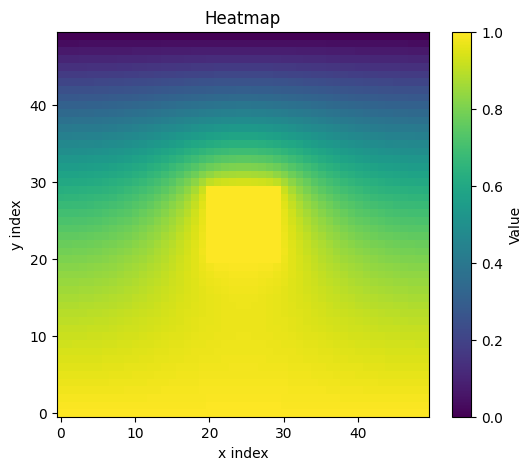

In [10]:
u_sor_sink1, err_sor_sink1 = successive_over_relaxation_sink(50,50,1.85,sinks = sink)
plot_heatmap(u_sor_sink1)

Converged after 482 iterations.


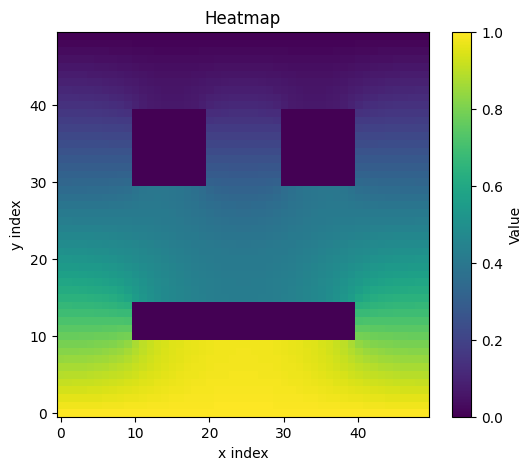

In [13]:
u_sor_insulating, err_sor_insulating = successive_over_relaxation_insulating(50,50,1.85,sinks = [[10,20,30,40],[30,40,30,40],[10,40,10,15]])
plot_heatmap(u_sor_insulating)